# Hyperparameters

In [1]:
IS_TRAINING_MODE = True

# training data paramters
TRAINING_PERCENT_PARAMETER = 0.15 #if IS_TRAINING_MODE else 0.015

# Development Parameters
DEBUG_PARAMETER = True
PARAM_FINAL_IMAGES = False
PARAM_GENERATE_CONFIDENCE_MATRIX = True

# Hyper parameters - these are from the last 15% run
sfs_features_to_select = 3
logistic_regression__C = 1.0
logistic_regression__class_weight = 'balanced'
logistic_regression__fit_intercept = False
logistic_regression__penalty = 'l2'
logistic_regression__solver = 'liblinear'
logistic_regression__features = None #['rb_count', 'extra_ol', 'form_I_FORM', 'form_PISTOL', 'form_SINGLEBACK', 'form_UNKNOWN', 'form_WILDCAT']
kneighbors__algorithm = 'auto'
kneighbors__n_neighbors = 10
kneighbors__weights = None
kneighbors__features = ['extra_ol', 'form_EMPTY', 'form_SHOTGUN']
decision_tree__criterion = 'entropy'
decision_tree__max_depth = 3
decision_tree__max_features = None
decision_tree__features = None#['wr_count', 'rb_count', 'form_SHOTGUN', 'form_SINGLEBACK']
svc__features = None #['is_inside_two_mins', 'wr_count', 'te_count', 'rb_count', 'form_SHOTGUN', 'form_SINGLEBACK']
random_forest__max_features = 7
random_forest__n_estimators = 3
gradient_boost__n_estimators = 32

# Initializing Data

## Preparing Data

In [2]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.utils import shuffle

from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector

# HalvingGridSearchCV is experimental and the API might change without any deprecation cycle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import auc as skl_auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier


### Load the Data

In [3]:
plays_path = '/Users/davidstange/Development/github/davestange/data/big_data_bowl_2025/plays.csv'
plays = pd.read_csv(plays_path)

plays.head()


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [4]:
games_path = '/Users/davidstange/Development/github/davestange/data/big_data_bowl_2025/games.csv'
games = pd.read_csv(games_path)

plays = plays.merge(games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], left_on='gameId', right_on='gameId')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,homeTeamAbbr,visitorTeamAbbr
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,CIN,ATL
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone,DAL,CIN
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone,HOU,TEN
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone,KC,TEN
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man,TB,BAL


## Readying the dataset

In [5]:
def get_position_features(s: pd.Series) -> pd.Series:
    ### determine wr, te, rb based on alignment; WRxTE
    wr_count = te_count = rb_count = 0
    extra_ol = s.offenseFormation == "JUMBO"
    if not isinstance(s.receiverAlignment, float):
        alignment = s.receiverAlignment.split('x')
        if len(alignment):
            wr_count = int(alignment[0])
            te_count = int(alignment[1])
            rb_count = 5 - wr_count - te_count
            if extra_ol and rb_count > 1:
                rb_count -= 1 

    return pd.Series([wr_count, te_count, rb_count, extra_ol], ['wr_count', 'te_count', 'rb_count', 'extra_ol'])
def get_time_features(s: pd.Series) -> pd.Series:
    ### determine total time remaining, is overtime, or within two mins 
    two_min_1st_half = 32 * 60
    two_min_2st_half = 2 * 60
    two_min_overtime = 68 * 60
    
    quarter = int(s.quarter)
    secs_remaining = math.nan
    is_inside_two_mins = is_overtime = False
    quarter_clock = s.gameClock.split(':')
    if len(quarter_clock) == 2:
        secs_in_quarter = int(quarter_clock[0]) * 60 + int(quarter_clock[1])
        if quarter <= 4:
            secs_remaining = (4 - quarter) * 15 * 60 + secs_in_quarter
        else:
            secs_remaining = secs_in_quarter
            is_overtime = True
        is_inside_two_mins = secs_in_quarter <= 120 and (quarter == 2 or quarter >= 4)

    return pd.Series([secs_remaining, is_inside_two_mins, is_overtime], ['secs_remaining', 'is_inside_two_mins', 'is_overtime'])

# v1 result - just sneak, kneel, spikie, pass, or run
plays['play_result'] = plays.apply(lambda p: 
                                   'run' if p.qbSneak == True else 
                                   'run' if p.qbKneel == True else 
                                   'pass' if p.qbSpike == True else 
                                   'pass' if p.isDropback == True else 
                                   'run', axis = 1)

# offenseFormation is NaN for qb kneels or spikes
plays['offense_formation'] = plays.apply(lambda p: 
                                   'UNKNOWN' if p.qbKneel == True else
                                   'UNKNOWN' if p.qbSpike == True else
                                   p.offenseFormation, axis = 1)


# get score and win probability
plays['score_offset'] = plays.apply(lambda p: 
                                    p.preSnapHomeScore - p.preSnapVisitorScore if p.possessionTeam == p.homeTeamAbbr else
                                    p.preSnapVisitorScore - p.preSnapHomeScore, axis = 1)
plays['win_probability'] = plays.apply(lambda p: 
                                       p.preSnapHomeTeamWinProbability if p.possessionTeam == p.homeTeamAbbr else
                                       p.preSnapVisitorTeamWinProbability, axis = 1)

# plays['high_liklihood_pass'] = plays.apply(lambda p: 
#                                             True if p.qbSpike == True else
#                                             False if p.qbKneel == True else
#                                             True if 
#                                             'UNKNOWN' if p.qbKneel == True else
#                                             p.offenseFormation, axis = 1)

# get position counts (TE, WR, etc)
tmp = plays.apply(get_position_features, axis=1)
plays['wr_count'] = tmp['wr_count']
plays['te_count'] = tmp['te_count']
plays['rb_count'] = tmp['rb_count']
plays['extra_ol'] = tmp['extra_ol']

tmp = plays.apply(get_time_features, axis=1)
plays['secs_remaining'] = tmp['secs_remaining']
plays['is_inside_two_mins'] = tmp['is_inside_two_mins']
plays['is_overtime'] = tmp['is_overtime']

# # preSnapHomeScore, preSnapVisitorScore, need Home/Away 
# plays['off_score_lead'] = plays.apply(...)

# # preSnapHomeTeamWinProbability	preSnapVisitorTeamWinProbability, need Home/Away 
# plays['off_win_probability'] = plays.apply(...)

plays['off_yards_to_goal'] = plays.apply(lambda p: 100 - int(p.yardlineNumber) if p.yardlineSide == p.possessionTeam else int(p.yardlineNumber), axis = 1)
df = plays

## Prepare the training set

In [6]:
formation_dummies = pd.get_dummies(df.offense_formation, prefix='form')
df = pd.concat([df, formation_dummies], axis=1)
quarter_dummies = pd.get_dummies(df.quarter, prefix='quarter')
df = pd.concat([df, quarter_dummies], axis=1)
down_dummies = pd.get_dummies(df.down, prefix='down')
df = pd.concat([df, down_dummies], axis=1)
# teams_dummies = pd.get_dummies(df.possessionTeam, prefix='team')
# df = pd.concat([df, teams_dummies], axis=1)

TARGET_FEATURE = 'play_result'
TRAINING_FEATURES = ['yardsToGo',                                                               # down and distance
                    #  'quarter', 'is_overtime', 'down',                                        # covered by dummies
                     'secs_remaining', 'is_inside_two_mins',                                    # game time
                     'wr_count', 'te_count', 'rb_count', 'extra_ol',                            # formations
                    #  'possessionTeam',                                                        # including team
                     'score_offset', 'win_probability',                                         # score and win probability
                     TARGET_FEATURE]
for c in formation_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in quarter_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in down_dummies.columns:
    TRAINING_FEATURES.append(c)
# for c in teams_dummies.columns:
#     TRAINING_FEATURES.append(c)

# set transformer of remaining categorical features
# col_trans = make_column_transformer(
#     (OneHotEncoder(drop = 'if_binary'), ['possessionTeam']),
#     remainder='passthrough')
df[TRAINING_FEATURES]

,yardsToGo,secs_remaining,is_inside_two_mins,wr_count,te_count,rb_count,extra_ol,score_offset,win_probability,play_result,...,form_WILDCAT,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4
0,10,1014,False,3,2,0,False,18,0.982017,pass,...,False,False,False,True,False,False,True,False,False,False
1,10,133,False,3,2,0,False,0,0.575644,pass,...,False,False,False,False,True,False,True,False,False,False
2,12,120,True,2,2,1,False,-14,0.006291,pass,...,False,False,False,False,True,False,False,False,True,False
3,10,3268,False,2,2,1,False,0,0.884223,pass,...,False,True,False,False,False,False,False,True,False,False
4,8,1036,False,3,1,1,False,0,0.589629,run,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,4,2569,False,2,2,1,False,-10,0.207444,pass,...,False,False,True,False,False,False,False,False,True,False
16120,10,752,False,2,2,1,False,2,0.724565,pass,...,False,False,False,False,True,False,True,False,False,False
16121,10,1499,False,2,2,1,False,4,0.834226,pass,...,False,False,False,True,False,False,True,False,False,False
16122,10,2745,False,2,2,1,False,4,0.519735,pass,...,False,True,False,False,False,False,True,False,False,False


In [7]:
tmp = df[TRAINING_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(TARGET_FEATURE, axis = 1), 
                                                    tmp[TARGET_FEATURE],
                                                    train_size=TRAINING_PERCENT_PARAMETER,
                                                    random_state=27,
                                                    stratify = df[TARGET_FEATURE])
if DEBUG_PARAMETER:
    print(f"The training set has {len(y_train)} rows")
    print(f"The test set has {len(y_test)} rows")
    print(f"The target feature is {TARGET_FEATURE} and the {len(X_train.columns)} training columns are {[x for x in X_train.columns]}")

The training set has 2418 rows
The test set has 13706 rows
The target feature is play_result and the 26 training columns are ['yardsToGo', 'secs_remaining', 'is_inside_two_mins', 'wr_count', 'te_count', 'rb_count', 'extra_ol', 'score_offset', 'win_probability', 'form_EMPTY', 'form_I_FORM', 'form_JUMBO', 'form_PISTOL', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_UNKNOWN', 'form_WILDCAT', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'down_1', 'down_2', 'down_3', 'down_4']


## Automation Layer

In [8]:
def create_confusion_matrix(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 20}, cbar = False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix for {model_name}')
    sns.set(font_scale = 2)
    
def create_confusion_matrix_2(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    disp1 = ConfusionMatrixDisplay(cm)
    disp1.plot()
    
def create_roc_curve(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc_value = skl_auc(fpr, tpr)

    disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp2.plot()

all_best_params = {}
def print_best_params(name, best_params):
    if IS_TRAINING_MODE:
        return
    print(f"======== Best Params for {name} ========")
    for key in best_params:
        value = best_params[key]
        if not isinstance(value, str):
            print(f"{key} = {value}")
        else:
            print(f"{key} = '{value}'")

def append_best_params(name, best_params):
    all_best_params.update(best_params)
    print_best_params(name, best_params)

all_runs = []
best_run = None
class ModelTrainer:
    def __init__(self, model_name, actual_model, generate_charts=True, selected_features=None):
        self.start_time = time.time()
        self.model_name = model_name
        self.model = actual_model
        self.generate_charts = False #generate_charts
        self.training_features = None
        self.train_time = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.features = selected_features if selected_features is not None else [x for x in TRAINING_FEATURES if x != TARGET_FEATURE]
        
    def elapsed(self):
        elapsed_time = time.time() - self.start_time
        return f"{elapsed_time:.4f} secs"
    
    def model_predict(self, X, is_continuous):
        prediction = self.model.predict(X)
        if is_continuous:
            prediction = (prediction >= 0.5).astype(int)
        return prediction
    
    def chart_roc_and_confusion(self, is_continuous):
        fig, ax = plt.subplots(1, 2)
        if PARAM_FINAL_IMAGES:
            fig.set_size_inches(20, 12)
        else:
            fig.set_size_inches(15, 5)

        preds = self.model_predict(X_test[self.features], is_continuous)

        # Confusion Matrix
        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            conf_matrix = confusion_matrix(y_test, preds)
            disp1 = ConfusionMatrixDisplay(conf_matrix)
            disp1.plot(ax=ax[0])

        # ROC Curve
        y_score = None
        if not is_continuous:
            y_score = self.model.predict_proba(X_test[self.features])[:, 1]
        else:
            y_score = self.model.predict(X_test[self.features])
        fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='run') # 
        roc_auc_value = skl_auc(fpr, tpr)

        disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
        disp2.plot(ax=ax[1])

    # def run_old(self, is_continuous=False):
    #     training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1
    #     self.model.fit(X_train, y_train)
    #     train_accuracy = accuracy_score(self.model_predict(X_train, is_continuous), y_train)
    #     self.predictions = self.model_predict(X_test, is_continuous)
    #     test_accuracy = accuracy_score(self.predictions, y_test) 
    #     all_runs.append(f"| {self.model_name} | {training_features} | {self.elapsed()} | {train_accuracy:4f} | {test_accuracy:4f} |")

    #     # ax = create_plots(2)
    #     # create_confusion_matrix_2(self.model_name, self.predictions, y_test, ax[0])
    #     # create_roc_curve(self.model, X_test, y_test, ax[1])
    #     if self.generate_charts:
    #         self.chart_roc_and_confusion(is_continuous)
    
    def run(self, is_continuous=False):
        features = self.features
        global best_run
        if not IS_TRAINING_MODE:
            print("Not training models - IS_TRAINING_MODE=False")
            return
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1

        model = self.model
        model.fit(X_train[features], y_train)
        predictions = model.predict(X_test[features])
        train_accuracy = accuracy_score(model.predict(X_train[features]), y_train)
        test_accuracy = accuracy_score(predictions, y_test) 
        self.training_features = training_features
        self.train_time = self.elapsed()
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy
        all_runs.append(self)
        if best_run is None or self.test_accuracy > best_run.test_accuracy:
            best_run = self

        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            self.chart_roc_and_confusion(False)

def optimize_model_params(pipeline, parameters_to_try):
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    model_finder = GridSearchCV(estimator = pipeline, 
                                param_grid = parameters_to_try, 
                                scoring = "accuracy",
                                n_jobs=-1,      # parallelization
                                cv = 5)
    model_finder.fit(X_train, y_train)
    append_best_params("LogisticRegression", model_finder.best_params_)

def show_run_output():
    if not IS_TRAINING_MODE:
        return
    print(f"*Best Run is {best_run.test_accuracy:4f} from {best_run.model_name}*\n")
    print("| Model | Features | Train Time | Train Accuracy | Test Accuracy |")
    print("| ----- | -------- | ---------- | -------------  | -----------   |")
    for r in all_runs:
        print(f"| {r.model_name} | {r.training_features} | {r.train_time} | {r.train_accuracy:4f} | {r.test_accuracy:4f} |")

def find_best_features(sq_model, max_features=8):
    best_accuracy = 0.0
    best_features = []

    for num_features in range(1, max_features + 1):
        start = time.time()
        selector = SequentialFeatureSelector(estimator=sq_model, n_features_to_select=num_features, n_jobs=-1)
        pipeline = Pipeline([
            # ('scaler', StandardScaler()),
            ('sequential', selector)
        ])
        X_sfs = pipeline.fit_transform(X_train, y_train)

        best_columns = selector.get_feature_names_out()

        sq_model.fit(X_train[best_columns], y_train)
        # train_accuracy = accuracy_score(sq_model.predict(X_train[best_columns]), y_train)
        test_accuracy = accuracy_score(sq_model.predict(X_test[best_columns]), y_test) 

        elapsed_time = time.time() - start
        print(f"Best Training Accuracy for {num_features}: {test_accuracy:4f} in {elapsed_time:.4f} secs, features: {selector.get_feature_names_out()}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_features = selector.get_feature_names_out()
    print(f"\nOverall Best: {best_accuracy:4f} features: {best_features}")
    return best_features


# Determine Hyperparameters

### Logistic Regression

In [10]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('logistic_regression', LogisticRegression(max_iter=10000))
])
parameters_to_try = {
    'logistic_regression__fit_intercept': [True, False],
    'logistic_regression__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'logistic_regression__C': [1.0, 100.0, 10000.0],
    'logistic_regression__class_weight': [None, 'balanced'],
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

optimize_model_params(pipeline, parameters_to_try)

NameError: name 'col_trans' is not defined

In [ ]:
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)
features = find_best_features(model)

# Overall Best: 0.741646 features: ['yardsToGo' 'extra_ol' 'form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK' 'form_UNKNOWN' 'form_WILDCAT']

Best Training Accuracy for 1: 0.684737 in 4.3286 secs, features: ['form_SINGLEBACK']
Best Training Accuracy for 2: 0.711659 in 1.9589 secs, features: ['form_I_FORM' 'form_SINGLEBACK']
Best Training Accuracy for 3: 0.723114 in 2.9113 secs, features: ['form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK']
Best Training Accuracy for 4: 0.732307 in 3.7990 secs, features: ['form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK' 'form_UNKNOWN']
Best Training Accuracy for 5: 0.736101 in 4.7666 secs, features: ['form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK' 'form_UNKNOWN'
 'form_WILDCAT']
Best Training Accuracy for 6: 0.741500 in 5.6071 secs, features: ['extra_ol' 'form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK' 'form_UNKNOWN'
 'form_WILDCAT']
Best Training Accuracy for 7: 0.741646 in 6.5142 secs, features: ['yardsToGo' 'extra_ol' 'form_I_FORM' 'form_PISTOL' 'form_SINGLEBACK'
 'form_UNKNOWN' 'form_WILDCAT']
Best Training Accuracy for 8: 0.741573 in 7.3952 secs, features: ['yardsToGo' 'secs_remaining' 'extra_ol' 'fo

### K-Nearest Neighbors

In [ ]:
pipeline = Pipeline([
    # ('transformer', col_trans),
    ('kneighbors', KNeighborsClassifier())
])
parameters_to_try = {
    'kneighbors__n_neighbors': np.array(range(1, 20)),
    'kneighbors__weights': [None, 'uniform', 'distance'],
    'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'kneighbors__leaf_sizeint': ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']
}

optimize_model_params(pipeline, parameters_to_try)

======== Best Params for LogisticRegression ========
kneighbors__algorithm = 'auto'
kneighbors__n_neighbors = 10
kneighbors__weights = None


In [ ]:
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
features = find_best_features(model)
# Overall Best: 0.741500 features: ['extra_ol' 'form_EMPTY' 'form_SHOTGUN']

Best Training Accuracy for 1: 0.664308 in 1.1957 secs, features: ['form_SHOTGUN']
Best Training Accuracy for 2: 0.603823 in 2.0149 secs, features: ['form_EMPTY' 'form_SHOTGUN']
Best Training Accuracy for 3: 0.741500 in 2.9130 secs, features: ['extra_ol' 'form_EMPTY' 'form_SHOTGUN']
Best Training Accuracy for 4: 0.740479 in 3.8723 secs, features: ['extra_ol' 'form_EMPTY' 'form_SHOTGUN' 'quarter_5']
Best Training Accuracy for 5: 0.740479 in 4.7664 secs, features: ['extra_ol' 'form_EMPTY' 'form_EMPTY' 'form_SHOTGUN' 'quarter_5']
Best Training Accuracy for 6: 0.740479 in 5.7252 secs, features: ['extra_ol' 'form_EMPTY' 'form_EMPTY' 'form_EMPTY' 'form_SHOTGUN'
 'quarter_5']
Best Training Accuracy for 7: 0.740479 in 7.0203 secs, features: ['extra_ol' 'form_EMPTY' 'form_EMPTY' 'form_EMPTY' 'form_EMPTY'
 'form_SHOTGUN' 'quarter_5']
Best Training Accuracy for 8: 0.740479 in 7.8258 secs, features: ['extra_ol' 'form_EMPTY' 'form_EMPTY' 'form_EMPTY' 'form_EMPTY'
 'form_EMPTY' 'form_SHOTGUN' 'quarte

### Decision Tree

In [ ]:
pipeline = Pipeline([
    # ('transformer', col_trans),
    ('decision_tree', DecisionTreeClassifier(criterion='entropy'))
])
parameters_to_try = {
    'decision_tree__criterion': ['gini', 'entropy', 'log_loss'],
    'decision_tree__max_depth': np.array(range(1, 20)),
    'decision_tree__max_features': [None, 'sqrt', 'log2'],
}

optimize_model_params(pipeline, parameters_to_try)

NameError: name 'col_trans' is not defined

In [ ]:
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
features = find_best_features(model)

# Overall Best: 0.740625 features: ['wr_count' 'rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']

Best Training Accuracy for 1: 0.684737 in 1.0781 secs, features: ['form_SINGLEBACK']
Best Training Accuracy for 2: 0.715891 in 1.9639 secs, features: ['rb_count' 'form_SINGLEBACK']
Best Training Accuracy for 3: 0.731431 in 2.8887 secs, features: ['rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 4: 0.740625 in 3.8586 secs, features: ['wr_count' 'rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 5: 0.740625 in 4.7584 secs, features: ['wr_count' 'rb_count' 'form_PISTOL' 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 6: 0.739311 in 5.6915 secs, features: ['wr_count' 'rb_count' 'form_PISTOL' 'form_SHOTGUN' 'form_SINGLEBACK'
 'quarter_2']
Best Training Accuracy for 7: 0.739311 in 6.5020 secs, features: ['wr_count' 'te_count' 'rb_count' 'form_PISTOL' 'form_SHOTGUN'
 'form_SINGLEBACK' 'quarter_2']
Best Training Accuracy for 8: 0.739311 in 7.4456 secs, features: ['wr_count' 'te_count' 'rb_count' 'extra_ol' 'form_PISTOL' 'form_SHOTGUN'
 '

### Support Vector Machines

In [ ]:
# pipeline = Pipeline([
#     ('transformer', col_trans),
#     ('regression', SVC(probability=False,        # avoid applying expensive Platt's calibration internally
#                        ))
# ])
# parameters_to_try = {
#     'regression__C': [0.1, 10, 1000], 
# 	'regression__gamma': [0.1, 10, 100], # 1, 0.1, 0.01, 0.001, 0.0001
# 	'regression__kernel': ['poly']
# }

# # scoring on HalvingGridSearchCV is failing due to wild
# # UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan.
# # model_finder = HalvingGridSearchCV(estimator = pipeline, 
# #                                    param_grid = parameters_to_try, 
# #                                    scoring = "accuracy",
# #                                    verbose=1)

# # switching to 
# model_finder = GridSearchCV(estimator = pipeline, 
#                             param_grid = parameters_to_try, 
#                             scoring = "accuracy",
#                             cv = 3,
#                             n_jobs=-1,      # parallelization
#                             verbose=99)
# model_finder.fit(X_train, y_train)
# append_best_params("LogisticRegression", model_finder.best_params_)

In [ ]:
model = SVC()
features = find_best_features(model)

# Overall Best: 0.740625 features: ['is_inside_two_mins' 'wr_count' 'te_count' 'rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']

Best Training Accuracy for 1: 0.684737 in 7.5903 secs, features: ['form_SINGLEBACK']
Best Training Accuracy for 2: 0.715891 in 13.2910 secs, features: ['rb_count' 'form_SINGLEBACK']
Best Training Accuracy for 3: 0.731359 in 18.8042 secs, features: ['rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 4: 0.740552 in 24.2763 secs, features: ['wr_count' 'rb_count' 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 5: 0.740552 in 29.9879 secs, features: ['is_inside_two_mins' 'wr_count' 'rb_count' 'form_SHOTGUN'
 'form_SINGLEBACK']
Best Training Accuracy for 6: 0.740625 in 35.2724 secs, features: ['is_inside_two_mins' 'wr_count' 'te_count' 'rb_count' 'form_SHOTGUN'
 'form_SINGLEBACK']
Best Training Accuracy for 7: 0.740625 in 40.7923 secs, features: ['is_inside_two_mins' 'wr_count' 'te_count' 'rb_count' 'extra_ol'
 'form_SHOTGUN' 'form_SINGLEBACK']
Best Training Accuracy for 8: 0.740625 in 46.4907 secs, features: ['is_inside_two_mins' 'wr_count' 'te_count' 'rb_c

### Ridge

In [ ]:
# pipeline = Pipeline([
#     ('transformer', col_trans),
#     ('ridge', Ridge)
# ])
# parameters_to_try = {
#     'ridge__alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
# }

# model_finder = GridSearchCV(estimator = pipeline, 
#                             param_grid = parameters_to_try, 
#                             scoring = "accuracy",
#                             n_jobs=-1,      # parallelization
#                             cv = 5)
# model_finder.fit(X_train, y_train)
# append_best_params("Ridge", model_finder.best_params_)

### Random Forest

In [ ]:
# model = RandomForestClassifier(n_estimators=5, max_features=10, oob_score=True)
# model.fit(...)
# model.oob_score_

pipeline = Pipeline([
    ('random_forest', RandomForestClassifier(n_estimators=5, max_features=10, oob_score=True))
])
parameters_to_try = {
    'random_forest__n_estimators': np.array(range(1, 5)),
    'random_forest__max_features': np.array(range(1, 10)),
}

optimize_model_params(pipeline, parameters_to_try)

/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-pa

======== Best Params for LogisticRegression ========
random_forest__max_features = 7
random_forest__n_estimators = 3


/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-pa

/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[0.6253101736972705, 0.6612903225806451, 0.6972704714640199, 0.7125723738626965, 0.7142266335814723, 0.7092638544251447, 0.7129859387923904, 0.7129859387923904, 0.7121588089330024, 0.7162944582299421, 0.7158808933002482, 0.7150537634408602, 0.7167080231596361]


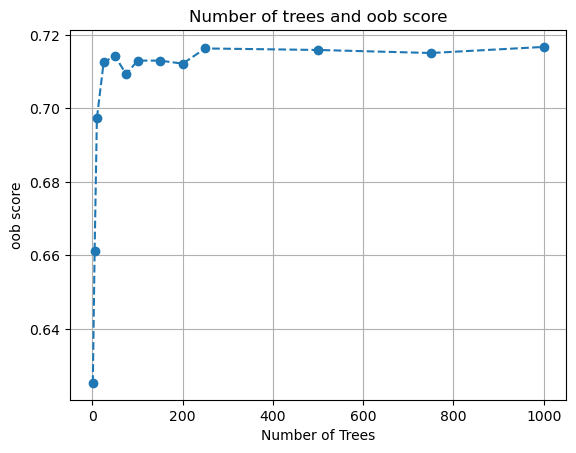

In [18]:
n_trees = [1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 750, 1000]

### GRADED
oob_scores = []
accuracy = []
for i in n_trees:
    f = RandomForestClassifier(random_state=42, n_estimators=i, oob_score=True).fit(X_train, y_train)
    oob_scores.append(f.oob_score_)
    accuracy.append(accuracy_score(f.predict(X_test), y_test))

### ANSWER CHECK
print(oob_scores)

plt.plot(n_trees, oob_scores, '--o')
plt.grid()
plt.title('Number of trees and oob score')
plt.xlabel('Number of Trees')
plt.ylabel("oob score");

[0.6432949073398512, 0.6874361593462717, 0.6977965854370348, 0.7119509703779366, 0.7155260469867212, 0.7158908507223114, 0.7146505180213045, 0.7164745366992558, 0.7144316357799504, 0.7157449292280753, 0.7145775572741865, 0.7155260469867212, 0.7158178899751934]


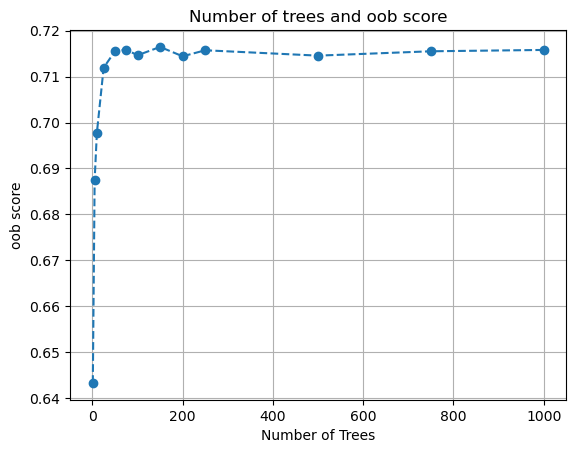

In [19]:
print(accuracy)

plt.plot(n_trees, accuracy, '--o')
plt.grid()
plt.title('Number of trees and oob score')
plt.xlabel('Number of Trees')
plt.ylabel("oob score");

### Gradient Boosting Ensemble

[0.7428133664088721, 0.7427404056617539, 0.7433970523858164, 0.7435429738800525, 0.7434700131329345, 0.7436888953742886, 0.7439077776156428, 0.7449292280752955, 0.7447103458339414, 0.7450021888224135, 0.745658835546476, 0.7458777177878302, 0.7466802860061287, 0.7463884430176565, 0.7462425215234204, 0.7460236392820663, 0.7455858747993579, 0.7458777177878302, 0.7452940318108857, 0.7453669925580038, 0.7459506785349482, 0.7460966000291843, 0.7457317962935941, 0.7452940318108857, 0.7447833065810594, 0.7450021888224135, 0.7450751495695316, 0.7449292280752955, 0.7446373850868233, 0.7439077776156428, 0.7441996206041149, 0.7444914635925872, 0.7442725813512331, 0.7441996206041149, 0.7447833065810594, 0.7441266598569969, 0.7444914635925872, 0.7447833065810594, 0.7448562673281774, 0.7444185028454692]
[0.7428133664088721, 0.7427404056617539, 0.7433970523858164, 0.7435429738800525, 0.7434700131329345, 0.7436888953742886, 0.7439077776156428, 0.7449292280752955, 0.7447103458339414, 0.7450021888224135,

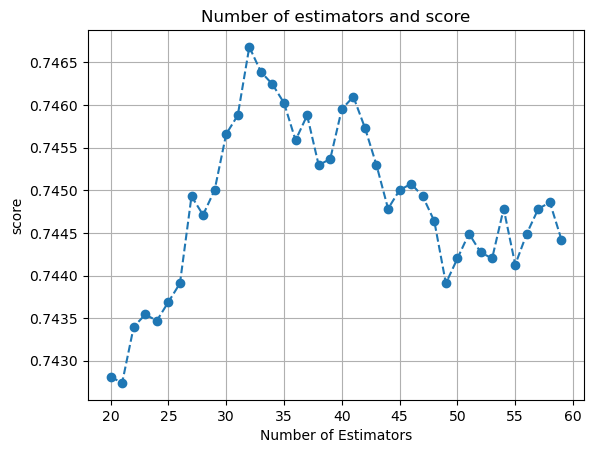

In [ ]:
gbc_estimators = np.array(range(20, 60))
gbc_scores = []
gbc_accuracy = []
for i in gbc_estimators:
    gbc = GradientBoostingClassifier(n_estimators=i)
    gbc.fit(X_train, y_train)
    gbc_score = gbc.score(X_test, y_test)
    gbc_scores.append(gbc_score)
    gbc_accuracy.append(accuracy_score(gbc.predict(X_test), y_test))

### ANSWER CHECK
print(gbc_scores)
print(gbc_accuracy)

plt.plot(gbc_estimators, gbc_scores, '--o')
plt.grid()
plt.title('Number of estimators and score')
plt.xlabel('Number of Estimators')
plt.ylabel("score");

# Runtime Models

### Baseline

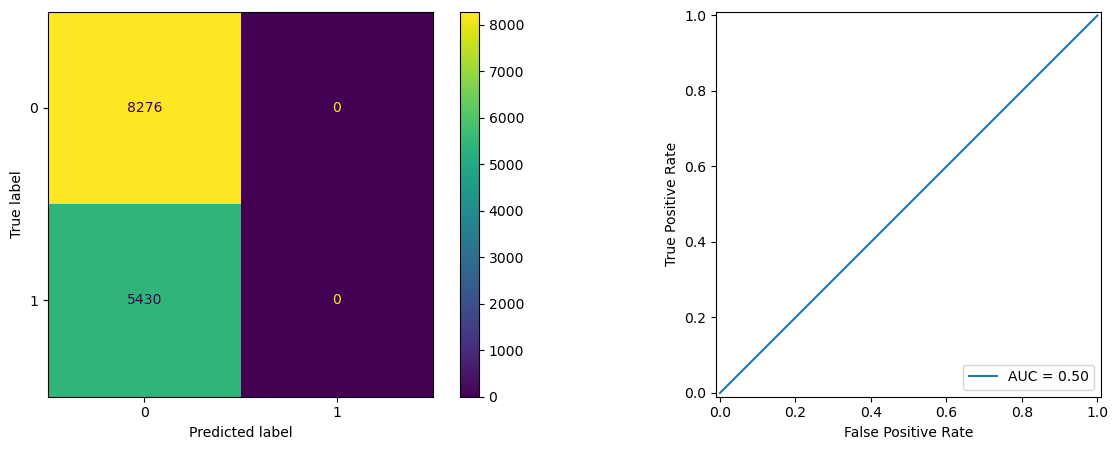

In [9]:
modeller = ModelTrainer(
    "Dummy", 
    DummyClassifier()
)
modeller.run()

### Logistic Regression

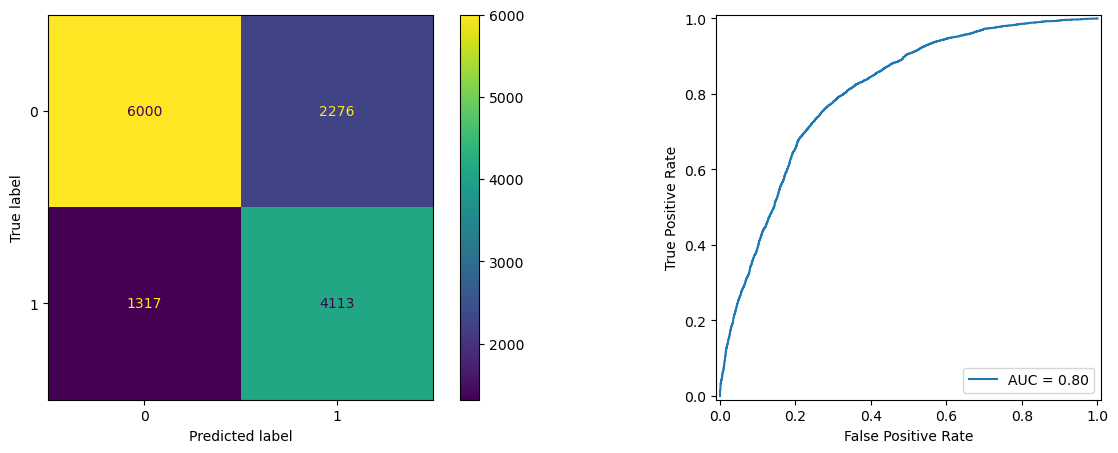

In [10]:
model_name = f"LogisticRegression (fit_intercept = {logistic_regression__fit_intercept}, penalty = {logistic_regression__penalty}, C = {logistic_regression__C}, class_weight = {logistic_regression__class_weight}, solver = {logistic_regression__solver})"
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)
ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            selected_features=logistic_regression__features).run()

### K-Nearest Neighbors

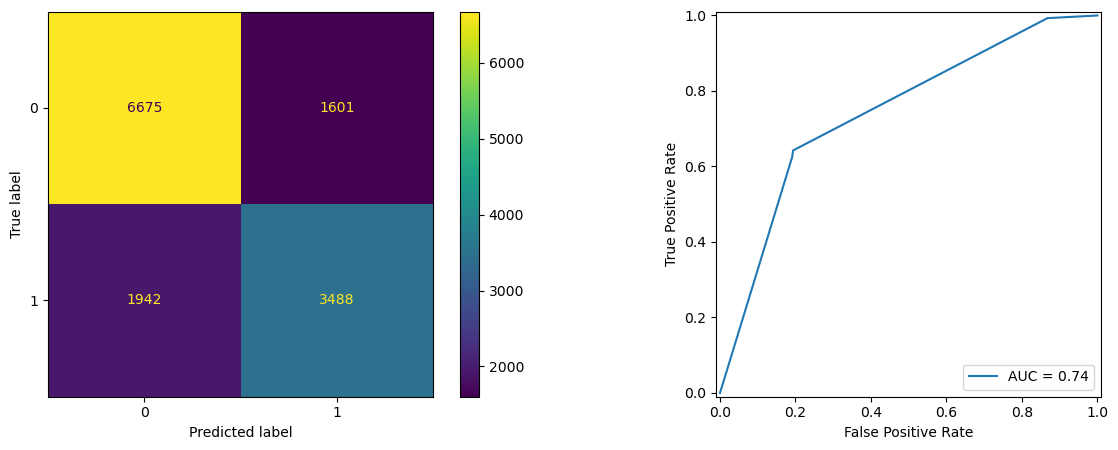

In [11]:
model_name = f"K-Nearest Neighbors (algorithm = {kneighbors__algorithm}, n_neighbors = {kneighbors__n_neighbors}, weights = {kneighbors__weights})"
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            selected_features=kneighbors__features).run()

### Decision Tree

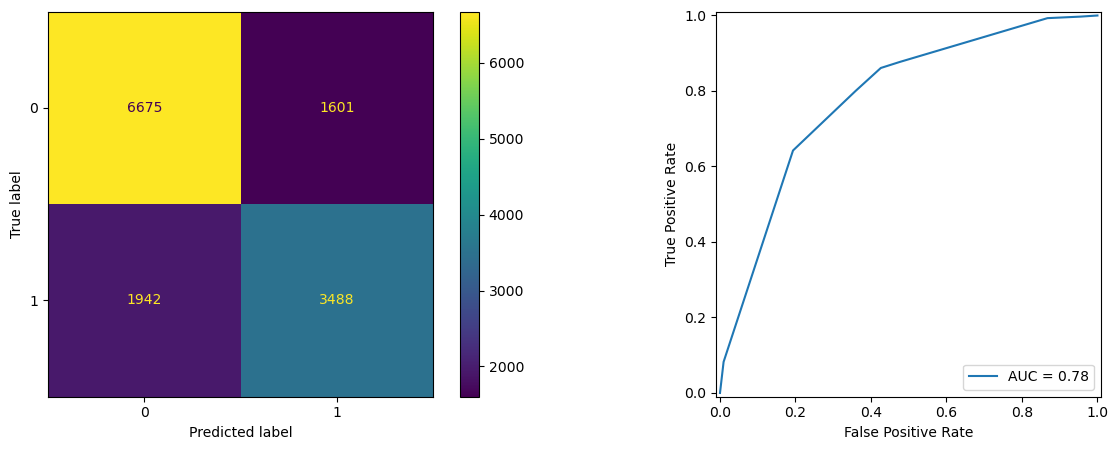

In [12]:
# for max_depth in range(1, 30):
model_name = f"DecisionTreeClassifier with (criterion={decision_tree__criterion}, max_depth={decision_tree__max_depth}, max_features={decision_tree__max_features})"
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            selected_features=decision_tree__features).run()

# # get cleaned up feature names
# feature_names = TRAINING_FEATURES

# fig = plt.figure(figsize=(100,30))
# _ = tree.plot_tree(model,
#                    feature_names=feature_names,
#                    filled=True)
# plt.suptitle("Decision Tree Classifier")

### Support Vector Machines

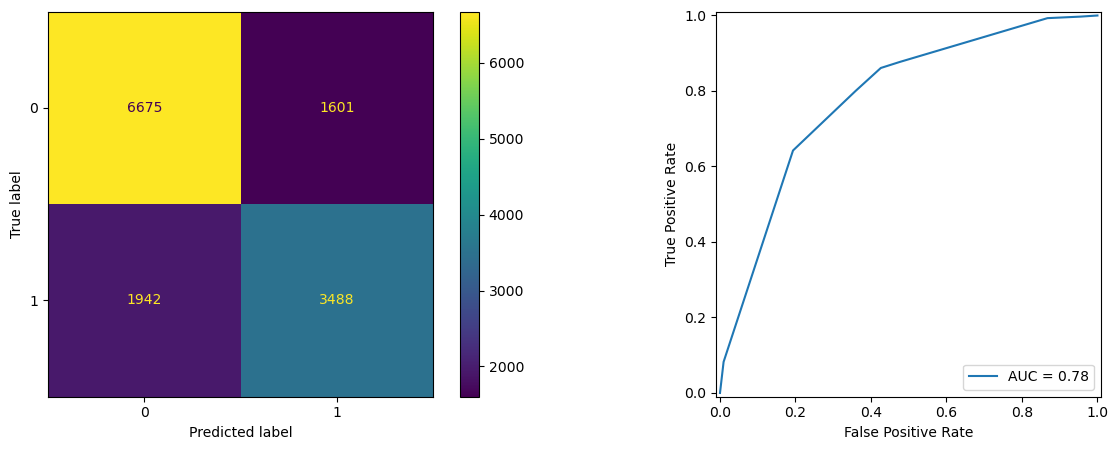

In [13]:
svc = SVC() #kernel=PARAM_SVM_KERNEL, gamma=PARAM_SVM_GAMMA, C=PARAM_SVM_C)
model_name = f"SVM (default params)"

ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            selected_features=svc__features).run()

### Ridge

/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


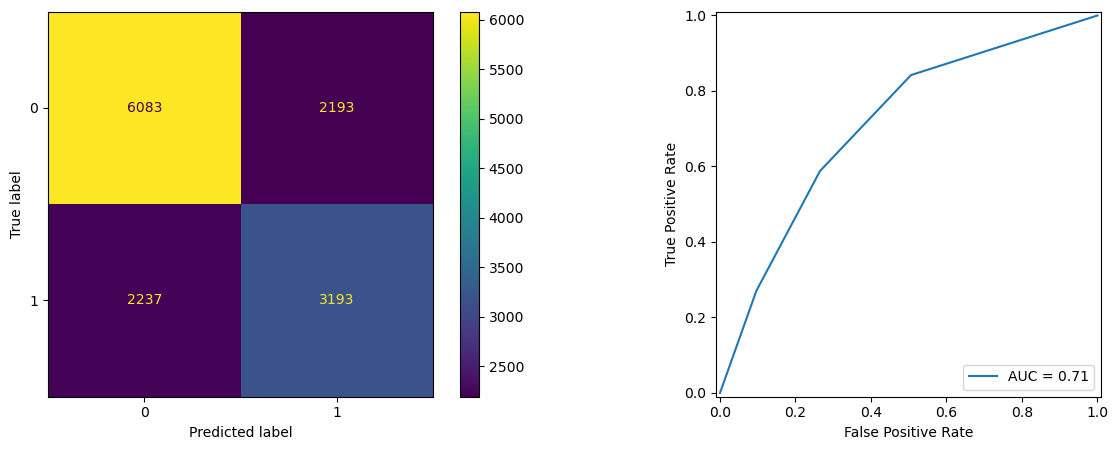

In [14]:
model_name = f"Ridge with StandardScaler"
model = Ridge()
model = RandomForestClassifier(n_estimators=random_forest__n_estimators, 
                               max_features=random_forest__max_features,
                               oob_score=True)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ])).run()

### Random Forest

/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


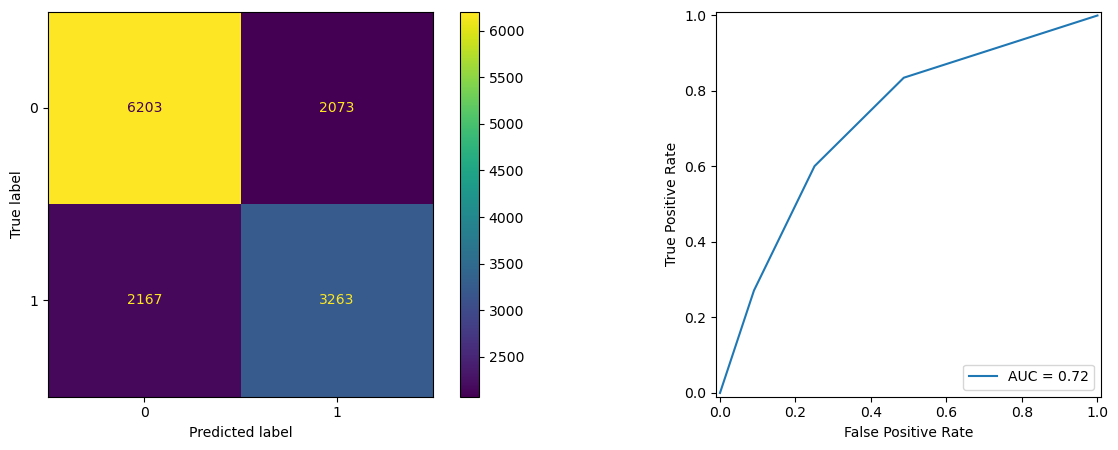

In [15]:
model_name = f"RandomForestClassifier with (n_estimators={random_forest__n_estimators}, max_features={random_forest__max_features})"
model = RandomForestClassifier(n_estimators=random_forest__n_estimators, 
                               max_features=random_forest__max_features,
                               oob_score=True)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ])).run()

### Gradient Boosting Ensemble

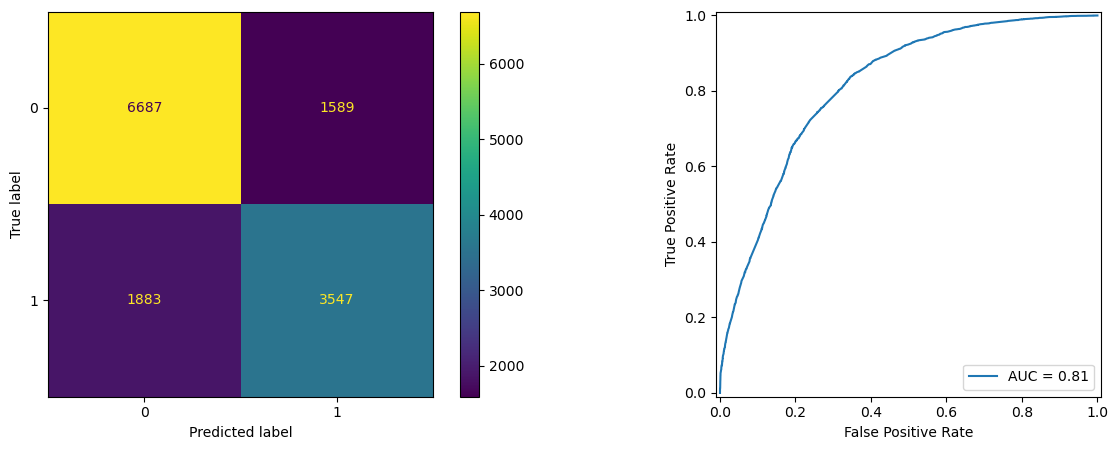

In [16]:
model_name = f"GradientBoostingClassifier with (n_estimators={gradient_boost__n_estimators})"
model = GradientBoostingClassifier(n_estimators=gradient_boost__n_estimators)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ])).run()

# Summary

In [17]:
print_best_params("All Hyperparameters", all_best_params)
show_run_output()

*Best Run is 0.746680 from GradientBoostingClassifier with (n_estimators=32)*

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.0218 secs | 0.603805 | 0.603823 |
| LogisticRegression (fit_intercept = False, penalty = l2, C = 1.0, class_weight = balanced, solver = liblinear) | 26 | 0.0187 secs | 0.734078 | 0.737852 |
| K-Nearest Neighbors (algorithm = auto, n_neighbors = 10, weights = None) | 26 | 0.0979 secs | 0.739454 | 0.741500 |
| DecisionTreeClassifier with (criterion=entropy, max_depth=3, max_features=None) | 26 | 0.0142 secs | 0.739454 | 0.741500 |
| SVM (default params) | 26 | 0.0143 secs | 0.739454 | 0.741500 |
| Ridge with StandardScaler | 26 | 0.0230 secs | 0.936725 | 0.676784 |
| RandomForestClassifier with (n_estimators=3, max_features=7) | 26 | 0.0209 secs | 0.937965 | 0.690646 |
| GradientBoostingClassifier with (n_estimators=32) | 26 | 0.0742 secs | 0.752275 | 0.746680 |
